In [81]:
import pandas as pd
df = pd.read_csv('SuicTweets.csv')
df.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [82]:
import re
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords_en = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juane\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juane\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [83]:
mapper = {
    1: 'Suicide',
    0: 'Non-suicide'
}
df['etiqueta'] = df['intention'].map(mapper)
df.head()

,tweet,intention,etiqueta
0,my life is meaningless i just want to end my l...,1,Suicide
1,muttering i wanna die to myself daily for a fe...,1,Suicide
2,work slave i really feel like my only purpose ...,1,Suicide
3,i did something on the 2 of october i overdose...,1,Suicide
4,i feel like no one cares i just want to die ma...,1,Suicide


In [84]:
import contractions
from tqdm import tqdm
tqdm.pandas()

def preprocesamiento_texto(texto):
    texto = texto.lower()
    texto = contractions.fix(texto)
    texto = re.sub(r'[^a-z\s]','', texto)
    texto_tokenized = word_tokenize(texto)
    texto_no_stop = [token for token in texto_tokenized if token not in stopwords_en]
    final = [lemmatizer.lemmatize (word) for word in texto_no_stop]
    final = ' '.join(final)
    return final

In [85]:

df['clean_tweet'] = df['tweet'].progress_apply(preprocesamiento_texto)
df.head()

100%|██████████| 9119/9119 [00:02<00:00, 3058.14it/s]


,tweet,intention,etiqueta,clean_tweet
0,my life is meaningless i just want to end my l...,1,Suicide,life meaningless want end life badly life comp...
1,muttering i wanna die to myself daily for a fe...,1,Suicide,muttering want die daily month feel worthless ...
2,work slave i really feel like my only purpose ...,1,Suicide,work slave really feel like purpose life make ...
3,i did something on the 2 of october i overdose...,1,Suicide,something october overdosed felt alone horribl...
4,i feel like no one cares i just want to die ma...,1,Suicide,feel like one care want die maybe feel le lonely


In [86]:
x = df['clean_tweet']
y = df['intention']

In [87]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.7,random_state=101, stratify=y)

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [89]:
from sklearn.pipeline import Pipeline

In [90]:
pipeline = Pipeline([('tfidf',TfidfVectorizer()),
                     ('model', RandomForestClassifier())])

In [91]:
from sklearn.model_selection import GridSearchCV

In [92]:
parameters   = {
    'tfidf__ngram_range': [(1,2), (1,3)],
    'model__n_estimators': [5, 10, 200]
}

In [93]:
grid = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-1, verbose=3, scoring='accuracy')

In [94]:
grid.fit(x_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'model__n_estimators': [5, 10, 200],
                         'tfidf__ngram_range': [(1, 2), (1, 3)]},
             scoring='accuracy', verbose=3)

In [95]:
grid.best_params_

{'model__n_estimators': 200, 'tfidf__ngram_range': (1, 2)}

In [96]:
grid.best_score_

0.8851641720752939

In [97]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [98]:
y_pred = grid.best_estimator_.predict(x_test)

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1536
           1       0.97      0.75      0.85      1200

    accuracy                           0.88      2736
   macro avg       0.90      0.87      0.87      2736
weighted avg       0.89      0.88      0.88      2736



<Axes: >

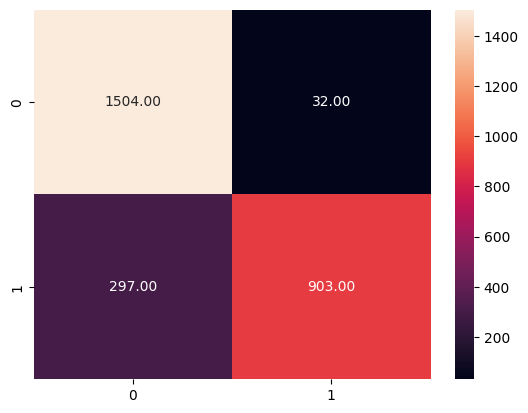

In [100]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.2f')